In [57]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

# System

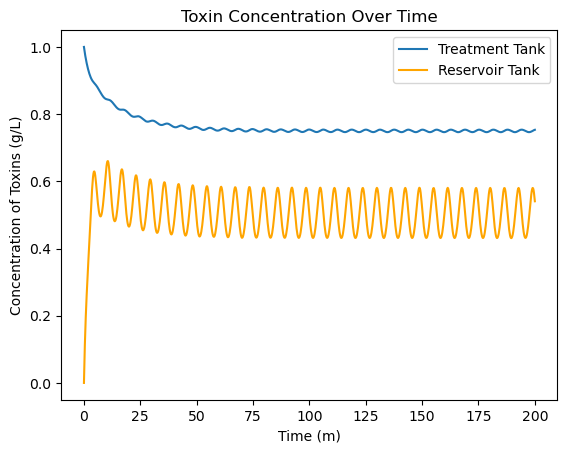

In [ ]:
# Define the system of differential equations
def tank_system(t, y):

    T_toxins, R_toxins = y  
    T_volume = 1000 + 50 + 50 - 100          
    R_volume = 300 + (50 + 50 * np.sin(t)) - 100 + 100 - 50  # Reservoir volume (L)

    # Flow rates (L/min)
    lake_to_treatment = 50
    treatment_to_reservoir = 100
    reservoir_to_treatment = 50
    spring_to_reservoir = 50 + 50 * np.sin(t)
    reservoir_to_city = 100

    # Concentrations (g/L)
    C_treatment = T_toxins / T_volume if T_volume > 0 else 0
    C_reservoir = R_toxins / R_volume if R_volume > 0 else 0
    C_lake = 1.0

    # Differential equations for total toxins in each tank
    dT_toxins_dt = (
        lake_to_treatment * C_lake               # Inflow from lake to treatment tank
        - treatment_to_reservoir * C_treatment   # Outflow from treatment to reservoir
        + reservoir_to_treatment * C_reservoir   # Inflow from reservoir to treatment tank
    )
    
    dR_toxins_dt = (
        spring_to_reservoir * 0                  # Spring water has no toxins
        + treatment_to_reservoir * C_treatment   # Inflow from treatment to reservoir
        - reservoir_to_city * C_reservoir        # Outflow to city from reservoir
        - reservoir_to_treatment * C_reservoir   # Outflow back to treatment tank
    )

    return [dT_toxins_dt, dR_toxins_dt]

# Initial conditions (total toxins in grams)
T_initial_toxins = 1000  
R_initial_toxins = 0     
y0 = [T_initial_toxins, R_initial_toxins]

# Time span for the simulation (200 minutes)
t_span = (0, 200)
t_eval = np.linspace(0, 200, 1000)

# Solve the system using solve_ivp
solution = solve_ivp(tank_system, t_span, y0, t_eval=t_eval, method='RK45')

# Extract results
time = solution.t
T_toxins = solution.y[0]
R_toxins = solution.y[1]

# Compute concentrations (g/L) for plotting alongside total toxins
T_concentration = T_toxins / 1000
R_concentration = R_toxins / (300 + (50 + 50 * np.sin(time)) - 100 + 50)

# Plot concentrations in g/L
plt.plot(time, T_concentration, label='Treatment Tank')
plt.plot(time, R_concentration, label='Reservoir Tank', color='orange')
plt.title('Toxin Concentration Over Time')
plt.xlabel('Time (m)')
plt.ylabel('Concentration of Toxins (g/L)')
plt.legend()
plt.show()


# Optimization Problem for Removal Rate

Optimal removal rate to achieve reservoir tank concentration < 0.5 g/L:  6.968586077831205


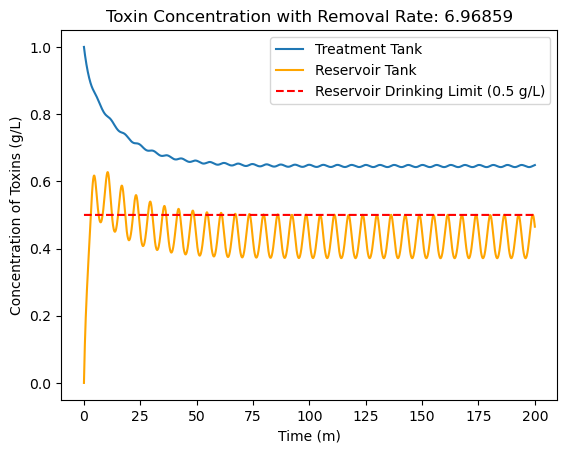

In [120]:
from scipy.integrate import solve_ivp

# Updated system with a removal rate from the treatment tank
def tank_system_with_removal(t, y, removal_rate):
    T_toxins, R_toxins = y
    T_volume = 1000 + 50 + 50 - 100          
    R_volume = 300 + (50 + 50 * np.sin(t)) - 100 + 100 - 50 

    lake_to_treatment = 50
    treatment_to_reservoir = 100
    reservoir_to_treatment = 50
    spring_to_reservoir = 50 + 50 * np.sin(t)
    reservoir_to_city = 100

    C_treatment = T_toxins / T_volume if T_volume > 0 else 0
    C_reservoir = R_toxins / R_volume if R_volume > 0 else 0
    C_lake = 1.0

    dT_toxins_dt = (
        lake_to_treatment * C_lake
        - treatment_to_reservoir * C_treatment
        + reservoir_to_treatment * C_reservoir
        - removal_rate   # Removal from treatment tank
    )

    dR_toxins_dt = (
        treatment_to_reservoir * C_treatment
        - reservoir_to_city * C_reservoir
        - reservoir_to_treatment * C_reservoir
    )

    return [dT_toxins_dt, dR_toxins_dt]


# Function to evaluate the maximum reservoir concentration for a given removal rate
def max_reservoir_concentration(removal_rate):
    removal_rate = removal_rate[0]  # Extract scalar from array
    y0 = [1000, 0]
    t_span = (0, 1000)  # Longer to ensure steady state
    t_eval = np.linspace(0, 1000, 2000)

    sol = solve_ivp(
        tank_system_with_removal, t_span, y0, args=(removal_rate,), t_eval=t_eval, method='RK45'
    )

    time = sol.t
    R_toxins = sol.y[1]
    R_volume = 300 + (50 + 50 * np.sin(time)) - 100 + 50
    R_concentration = R_toxins / R_volume
    R_concentration = R_concentration[-100:]  # Steady state

    return np.max(R_concentration)


# Search for the minimal removal rate that keeps concentration <= 0.5 g/L
optimal_removal_rate = fsolve(lambda r: max_reservoir_concentration(r) - 0.5, [5])[0]
print("Optimal removal rate to achieve reservoir tank concentration < 0.5 g/L: ", optimal_removal_rate)

#Plot the concentration of the two tanks with the optimal removal rate
y0 = [1000, 0]
t_span = (0, 200)  # Longer to ensure steady state
t_eval = np.linspace(0, 200, 2000)

# Solve the system with the optimal removal rate
sol = solve_ivp(
    tank_system_with_removal, t_span, y0, args=(optimal_removal_rate,), t_eval=t_eval, method='RK45'
)

# Extract results
time = sol.t
T_toxins = sol.y[0]
R_toxins = sol.y[1]

# Compute concentrations (g/L) for plotting alongside total toxins
T_concentration = T_toxins / 1000  # Treatment tank concentration (g/L)
R_concentration = R_toxins / (300 + (50 + 50 * np.sin(time)) - 100 + 50)  # Reservoir concentration (g/L)

# Plot concentrations in g/L
plt.plot(time, T_concentration, label='Treatment Tank')
plt.plot(time, R_concentration, label='Reservoir Tank', color='orange')
plt.plot(time, [0.5] * len(time), label='Reservoir Drinking Limit (0.5 g/L)', linestyle='--', color='red')
plt.title('Toxin Concentration with Removal Rate: {:.5f}'.format(optimal_removal_rate))
plt.xlabel('Time (m)')
plt.ylabel('Concentration of Toxins (g/L)')
plt.legend()
plt.show()


# Earthquake Dilemma

1. The first place that I would want to check would most likely be treatment tank. The reason that I believe that this pipe could have been damaged is because the amount of water in the reservoir tank is down, indicating that there is most likely a problem with water coming into the tank, which narrows it down to the spring intake and the intake from the treatment tank. Since the algal toxin levels are also down, this indicates that the spring water is running smoothly still, but the treatment tank water is not making it to the reservoir tank. I would check the actual treatment center before the pipe or pump because if there is a problem with the treatment center itself, such as a massive leak or serious damage to the center, this has the most potential to turn into a flood and also would take the longest time to fix/repair - thus it needs the attention first.
2. If the treatment center was working properly, then I would take a look at the pipe going from the treatment center to the reservoir tank. If there is a problem with the pipe, such as a leak or break, we want to prevent water from flooding or spilling out into surrounding areas. It wouldn't be as hard to fix as the entire treatment center, but it could still cause problems.
3. Lastly, I would check the pump as this would be an easier fix and would have less potential to cause flooding in the surrounding areas.